## Using LSTM to Predict Microsoft Stock Price - With Feature Engineering

<p> Date: 2026-11-8 &emsp;&emsp;&emsp; 
<br><br> 

**Source Data**: [New York Stock Exchange](https://www.kaggle.com/datasets/dgawlik/nyse?select=securities.csv)

**Content:** <br>
- [Background](#background)

- [Jump to Experiemnt 🧪⚗️ ](#experiment)

    - [Modeling](#modeling)

    - [Prediction](#prediction)

- [Reference]() 

## Background

### 1. Stock Analysis using Recurrent Neural Networks (RNNs):

1. `LSTM = Long Short-Term Memory`; GRU = Gated Recurrent Units  
    - The classic approach: use a sequence of past price (and optionally volume/indicators) to forecast next price or return. e.g., using TensorFlow / Keras you can build a straightforward LSTM model. 
    - Example: Using x_train of shape (time_steps, features) and LSTM layers, return_sequences, etc. 
    - Also GRU variants (Gated Recurrent Units) appear in literature. 

### 2. Feature Engineering

Adding open, high, low, and volume can help, but whether it improves your model depends on multiple factors:

1. Why adding them could help
    - Open, high, low: Provide intra-day movement information. LSTM can potentially capture patterns like volatility, gaps, etc.
    - Volume: Often correlates with price momentum and can indicate strong buying/selling pressure. LSTM could learn relationships between volume spikes and price changes.

2. Why it might not help
    - **Redundancy**: Closing price is already a summary of the day. High and low may not add much signal if your prediction horizon is daily and the LSTM captures trends from closing prices.
    - **Noise**: Extra features introduce more parameters for the model to learn. If the stock’s movement is mostly trend-based and predictable from the close price alone, extra features could just add noise.
    - **Data scarcity**: For short time series (like <2000 days), adding more features increases risk of overfitting.

**Rule of thumb**: Adding more features can help but is not guaranteed. It’s better to test feature sets and validate than assume more features always improve LSTM performance.


### 2.1 Table 

| Feature Nam         | Description / How to Compute                                            | Notes / Why Useful                        |
| ------------------- | ----------------------------------------------------------------------- | ----------------------------------------- |
| Close               | Closing price of the day                                                | Baseline target for prediction            |
| Open                | Opening price                                                           | Optional: can capture gap moves           |
| High                | Daily high                                                              | Helps measure intra-day extremes          |
| Low                 | Daily low                                                               | Combined with High, gives volatility info |
| Volume              | Trading volume                                                          | Indicates buying/selling pressure         |
| Volume_Change       | `(Volume_t - Volume_{t-1}) / Volume_{t-1}`                              | Detects unusual volume spikes             |
| Return_1d           | `(Close_t - Close_{t-1}) / Close_{t-1}`                                 | Daily return / momentum                   |
| Return_7d           | `(Close_t - Close_{t-7}) / Close_{t-7}`                                 | Short-term momentum                       |
| Streak_Up           | Count of consecutive days `Close_t > Close_{t-1}`                       | Captures buying pressure                  |
| Streak_Down         | Count of consecutive days `Close_t < Close_{t-1}`                       | Captures selling pressure                 |
| ATR_7               | Average True Range over 7 days: mean of `(High - Low)` or `(max - min)` | Measures short-term volatility            |
| MA_5                | 5-day moving average of close                                           | Trend indicator                           |
| MA_10               | 10-day moving average of close                                          | Trend indicator                           |
| MA_ratio            | `MA_5 / MA_10`                                                          | Crossovers may indicate momentum shifts   |
| Price_Volume_Signal | `Return_1d * Volume_Change`                                             | Combined price + volume momentum signal   |
| True Range(TR)      | `max(High - Low, abs(High - PrevClose), abs(Low - PrevClose))           | Captures true daily volatility including overnight gaps |
|**Range Ratio**      | `(High - Low) / Close`                                                  |Simpler, normalized volatility measure — used in quantitative screening and neural network inputs.| 



## Experiment


In [ ]:
# ##### ===== System Setup ==== ##### 
# uncomment the code below for a more automatic folder and log function 

# %load_ext dotenv
# %dotenv

# import os, sys
# from utils.logger import get_logger
# from datetime import datetime

# _logs = get_logger(__name__)
# _logs.info(f"Hello World! Today is {datetime.now().strftime('%A, %B %d, %Y')}")

# # sys.path.append(os.getenv('SRC_DIR'))

In [1]:
##### >>> 1: Testing with APPL(Apple)  

### >> 1.1 Load Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


2025-11-09 01:48:44.255805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-09 01:48:44.270103: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-09 01:48:44.274877: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-09 01:48:44.285623: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-09 01:48:44.848277: W tensorflow/compiler/tf2

In [2]:
### >> 1.2 Load the price data, AAPL 
FILE_PATH = "../../data/raw"
RAW_FILE = os.path.join(FILE_PATH, "prices-split-adjusted.csv")

Tick = 'MSFT'

df = pd.read_csv(RAW_FILE, parse_dates=["date"])
df = df.groupby('symbol').filter(lambda x: len(x) > 1500) # only select more data with more than 1500 records 
# check for NaN or Null 
print(df.isnull().sum())
print(f"Any NA: {df.isna().any().any()}")  # False

print(f"Ticker: {Tick}")
print(f"Data Exist: {Tick in df['symbol'].unique() }")

df = df[df["symbol"] == Tick].sort_values("date")  # Example: AAPL
df = df[["date", "open", "high", "low", "close", "volume"]].set_index("date")

# ============================================================
# >> 1.3 Feature Engineering
# ============================================================

# 1. Volume change (%)
#   - For now, check if 'volume' exists first (some Kaggle subsets may not include it)
if 'volume' in df.columns:
    df['vol_change'] = df['volume'].pct_change()
else:
    df['vol_change'] = np.nan  # placeholder if volume not in dataset

# 2. 7-day return (%)
df['return_7d'] = df['close'].pct_change(periods=7)

# 3. Streak up (consecutive up days)
streak_up = []
count = 0
for i in range(len(df)):
    if i == 0:
        count = 0
    elif df['close'].iloc[i] > df['close'].iloc[i - 1]:
        count += 1
    else:
        count = 0
    streak_up.append(count)
df['streak_up'] = streak_up

# 4. Streak down (consecutive down days)
streak_down = []
count = 0
for i in range(len(df)):
    if i == 0:
        count = 0
    elif df['close'].iloc[i] < df['close'].iloc[i - 1]:
        count += 1
    else:
        count = 0
    streak_down.append(count)
df['streak_down'] = streak_down

# 5. Range ratio (normalized daily volatility)
#   - You’ll need high and low columns from the dataset for this
if {'high', 'low'}.issubset(df.columns):
    df['range_ratio'] = (df['high'] - df['low']) / df['close']
else:
    df['range_ratio'] = np.nan  # placeholder if columns missing

# Drop initial NaN from pct_change calculations
df = df.dropna()

# Show summary
print(f"Number of record: {len(df)}")
df.tail()

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64
Any NA: False
Ticker: MSFT
Data Exist: True
Number of record: 1755


,open,high,low,close,volume,vol_change,return_7d,streak_up,streak_down,range_ratio
date,,,,,,,,,,
2016-12-23,63.450001,63.540001,62.799999,63.240002,12403800.0,-0.440681,0.008934,0,1,0.011701
2016-12-27,63.209999,64.070000,63.209999,63.279999,11763200.0,-0.051645,0.011186,1,0,0.013590
2016-12-28,63.400002,63.400002,62.830002,62.990002,14653300.0,0.245690,0.011075,0,1,0.009049
2016-12-29,62.860001,63.200001,62.730000,62.900002,10250600.0,-0.300458,-0.011317,0,2,0.007472
2016-12-30,62.959999,62.990002,62.029999,62.139999,25579900.0,1.495454,-0.022033,0,3,0.015449


## Modeling

**Key Concept**

1. **`create_dataset`**:

    - series[i:i+look_back]: takes a window of look_back consecutive days as input.  

    - series[i+look_back]: the next day after the window is the target.  

    | Input window (`X`) | Target (`y`) |
    | ------------------ | ------------ |
    | day 0–19           | day 20       |
    | day 1–20           | day 21       |
    | day 2–21           | day 22       |
    | …                  | …            |

    For a series of length 100, the number of (X, y) pairs is: 

    <p style="text-align:left;"><em>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;100 - 20 = 80</em></p>

    So you end up with 80 rows of training data

2. `model.fit()`: set shuffle = False as this is time series 

3. 

```text
            ┌─────────────────────────────────────────┐
            │               Input Layer               │
            │         (20 timesteps × 6 features)     │
            └────────────────────┬────────────────────┘
                                 │
                                 ▼
            ┌─────────────────────────────────────────┐
            │                LSTM Layer               │
            │            50 hidden units              │
            │   Learns temporal dependencies          │
            │                                         │
            │ Total params: 36,755                    │
            │ Trainable params: 12,251                │
            │ Non-trainable params: 0                 │
            │ Optimizer params: 24,504                │
            └─────────────────────┬───────────────────┘
                                  │
                                  ▼
            ┌─────────────────────────────────────────┐
            │               Dense Output              │
            │                 (1 neuron)              │
            │        Predicts next-day price          │
            └─────────────────────────────────────────┘

```

In [3]:
##### >>> 2. LSTM Model Construction 

# Scale data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# define a helper fucntion to create a supervised data as input sequence (the sliding window and look_back = 20)
# with a multiple input columns, each y should usually predict one target (e.g., next-day close), not the full feature vector -> add # target_col
def create_dataset(series, look_back, target_col=0):   # 
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:i+look_back, :]) # all features for look_back days
        y.append(series[i+look_back, target_col])
    return np.array(X), np.array(y)


# create train, test data for both x and y
X, y = create_dataset(scaled, 20, target_col=0)  # <- set look_back = 20 days
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# split for validation
split_val = int(len(X_train)*0.2) # 20% of last training data for validation
X_train_sub, X_val = X_train[:-split_val], X_train[-split_val:]
y_train_sub, y_val = y_train[:-split_val], y_train[-split_val:]

print(X_train.shape)
print(y_train.shape)

(1388, 20, 10)
(1388,)


In [4]:
### >> 2.2 Create a helper function

def create_lstm_model(input_shape):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        LSTM(50, activation='tanh'),  # 50 memory unit, common values are :32, 50. 64
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

#### **LSTM expects input in 3D shape**

| Dimension| Symbol             | Example value | Meaning                                                           |
| ---------| ------------------ | ------------- | ----------------------------------------------------------------- |
| 1        | `X_train.shape[0]` | e.g. 3000     | Number of sequences (samples) you created from your data          |
| 2        | `X_train.shape[1]` | e.g. 60       | Number of **time steps** in each sequence (the “lookback window”) |
| 3        | `X_train.shape[2]` | e.g. 1        | Number of **features per time step** (columns in your input)      |


Another way to think about is:
1. Time step ([1]): How many past days the model looks back? 
2. Feature per time step ([2]):	How many variables per day? only close or open, close,? 


#### Different Metrics Guide

| Metric                                    | Penalizes Large Errors? |  Scale-Dependent? |          Robust to Outliers?          | Gradient Behavior                                                                              | Common Use / Strength                                                           | Drawbacks                                                   | Best For                                                                   |
| :---------------------------------------- | :---------------------: | :---------------: | :-----------------------------------: | :--------------------------------------------------------------------------------------------- | :------------------------------------------------------------------------------ | :---------------------------------------------------------- | :------------------------------------------------------------------------- |
| **MSE** (Mean Squared Error)              |        ✅ Strongly       |       ✅ Yes       |                  ❌ No                 | ✅ Smooth, differentiable everywhere; larger gradients for bigger errors → good for neural nets | Emphasizes large mistakes; useful in training models (esp. NN/gradient descent) | Harder to interpret (units²); overly influenced by outliers | Optimizing NN models or when you want to heavily penalize large deviations |
| **RMSE** (Root Mean Squared Error)        |       ✅ Moderately      |       ✅ Yes       |                  ❌ No                 | ✅ Smooth (same as MSE, just transformed)                                                       | Same benefits as MSE but interpretable (same units as target)                   | Still sensitive to large errors                             | Reporting model accuracy in stock price units                              |
| **MAE** (Mean Absolute Error)             |         ❌ Linear        |       ✅ Yes       |                 ✅ Yes                 | ⚠️ Constant gradient almost everywhere, not smooth at zero → slower NN convergence             | Stable metric; simple to explain (“avg error = $X”)                             | Slower training in NN; doesn’t highlight big mistakes       | Evaluating performance robustly or for non-NN models                       |
| **MAPE** (Mean Absolute Percentage Error) |         ❌ Linear        | ❌ No (unitless %) | ❌ No (unstable for small true values) | ⚠️ Non-smooth due to division by target                                                        | Easy to interpret as percentage error; good for cross-stock comparison          | Undefined/unstable if price ≈ 0; biased toward low values   | Comparing models across stocks with different price ranges                 |



In [5]:
##### >>> 3.2 Train LSTM : different seed x 3 to see if the model stable >> consistency result 
from tqdm import tqdm

metrics=[]
histories=[]
predictions=[]
seeds=[111,222,333]

for i in tqdm(range(3)): 
    random.seed(seeds[i])
    np.random.seed(seeds[i])
    tf.random.set_seed(seeds[i])
    ## >> Train
    n_steps = X_train.shape[1]; n_features = X_train.shape[2]
    model_lstm = create_lstm_model((n_steps,n_features))
    
    history = model_lstm.fit(X_train_sub, y_train_sub, validation_data=(X_val, y_val), 
                             shuffle=False, epochs=20, batch_size=16, verbose=0) # time series, need to set shuffer = False
    histories.append(history)

    ## >> Predict
    y_pred = model_lstm.predict(X_test)
    n_features = scaled.shape[1]  # number of columns scaler was fit on
    # Prepare y_pred for inverse transform
    y_pred_pad = np.zeros((len(y_pred), n_features))
    y_pred_pad[:, 0] = y_pred.flatten()   # put predicted close into the first column
    y_pred_inv = scaler.inverse_transform(y_pred_pad)[:, 0]  # take only the close column

    # Same for y_test
    y_test_pad = np.zeros((len(y_test), n_features))
    y_test_pad[:, 0] = y_test.flatten()
    y_test_inv = scaler.inverse_transform(y_test_pad)[:, 0]

    residuals = y_test_inv - y_pred_inv
    
    ## >> Save individual run results
    predictions.append({
        "Run": i+1,
        "Seed": seeds[i],
        "y_test": y_test_inv.copy(),
        "y_pred": y_pred_inv.copy()
    })

    # Metrics
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(residuals / y_test_inv)) * 100
    # Compute directional accuracy
    # np.diff calculates day-to-day changes
    # np.sign gets the direction (+1 up, -1 down)
    direction_match = np.sign(np.diff(y_pred_inv, axis=0)) == np.sign(np.diff(y_test_inv, axis=0))
    direction_accuracy = np.mean(direction_match) * 100  # convert to percentage

    # --- Save results for comparison ---
    metrics.append({
        "Ticker": Tick,
        "Run": i+1,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "DirAcc (%)": direction_accuracy
    })
model_lstm.summary()

results_metrics_df = pd.DataFrame(metrics)

print(results_metrics_df.to_string(index=False, float_format="%.4f"))


  0%|          | 0/3 [00:00<?, ?it/s]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 33%|███▎      | 1/3 [00:07<00:15,  7.54s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 67%|██████▋   | 2/3 [00:15<00:07,  7.53s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


100%|██████████| 3/3 [00:22<00:00,  7.54s/it]


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,755 (143.58 KB)

 Trainable params: 12,251 (47.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,504 (95.72 KB)

Ticker  Run    MSE   RMSE    MAE   MAPE  DirAcc (%)
  MSFT    1 0.9880 0.9940 0.7438 1.3571     74.5665
  MSFT    2 0.7661 0.8753 0.6266 1.1589     72.2543
  MSFT    3 0.6525 0.8078 0.5543 1.0304     73.1214


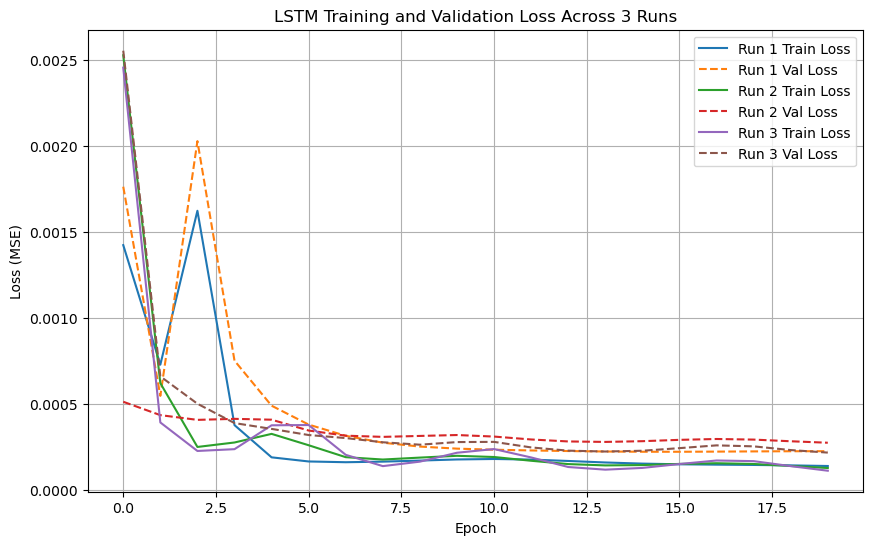

In [6]:
## training plot
plt.figure(figsize=(10,6))
for run in range(3):
    history = histories[run]
    plt.plot(history.history['loss'], label=f'Run {run+1} Train Loss')
    plt.plot(history.history['val_loss'], '--', label=f'Run {run+1} Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('LSTM Training and Validation Loss Across 3 Runs')
plt.legend()
plt.grid(True)
plt.show()

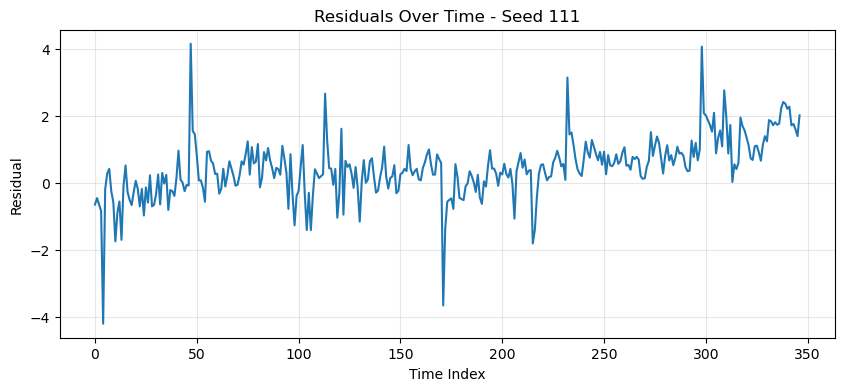

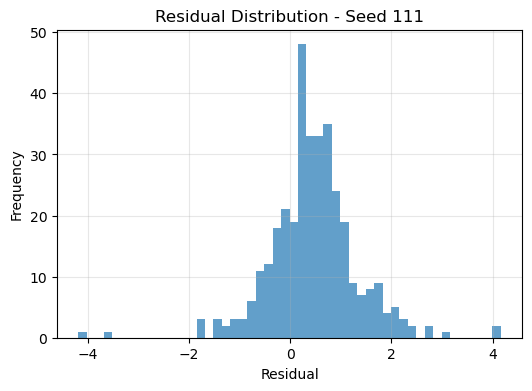

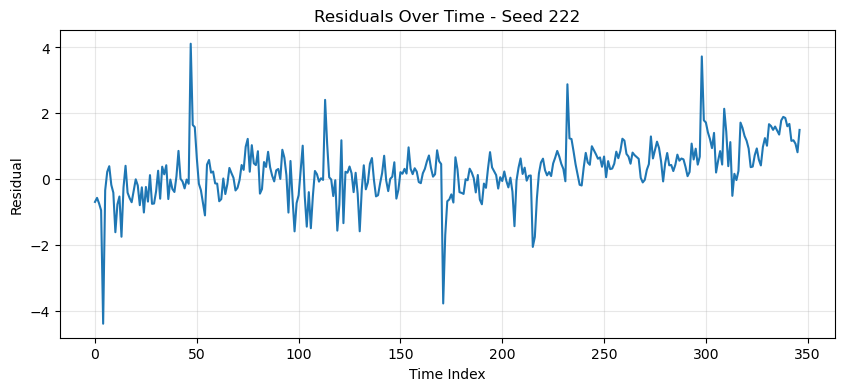

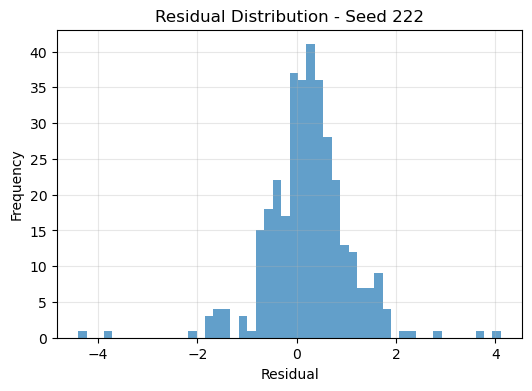

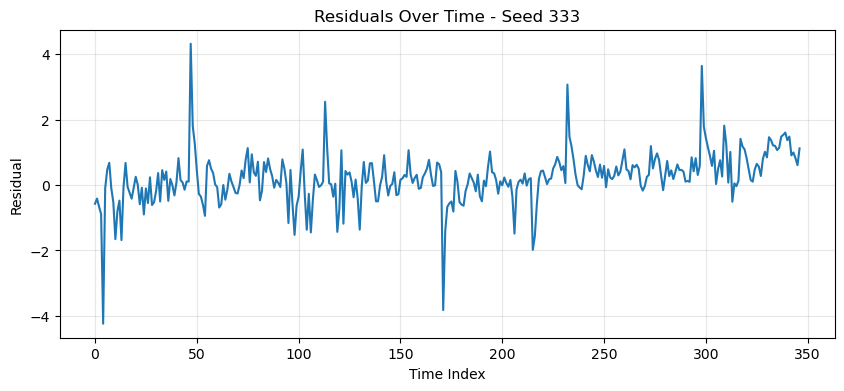

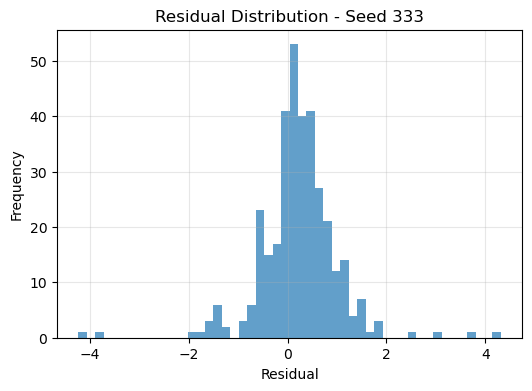

In [7]:
##### >>> 4. Model Robustness Performance Analysis - 
### >>  Residual Plot and Histrogram >> Loop through all predictions (3 seeds)
for i, pred in enumerate(predictions):
    residuals = pred["y_test"] - pred["y_pred"]
    
    # Residual over time
    plt.figure(figsize=(10,4))
    plt.plot(residuals, color="#1f77b4")
    plt.title(f"Residuals Over Time - Seed {pred['Seed']}")
    plt.xlabel("Time Index")
    plt.ylabel("Residual")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Residual histogram
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=50, alpha=0.7) #color="#ff7f0e", edgecolor="#ff7f0e"
    plt.title(f"Residual Distribution - Seed {pred['Seed']}")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.show()

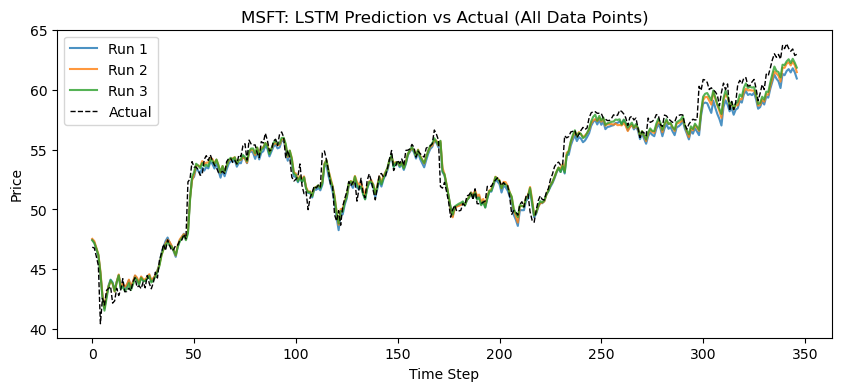

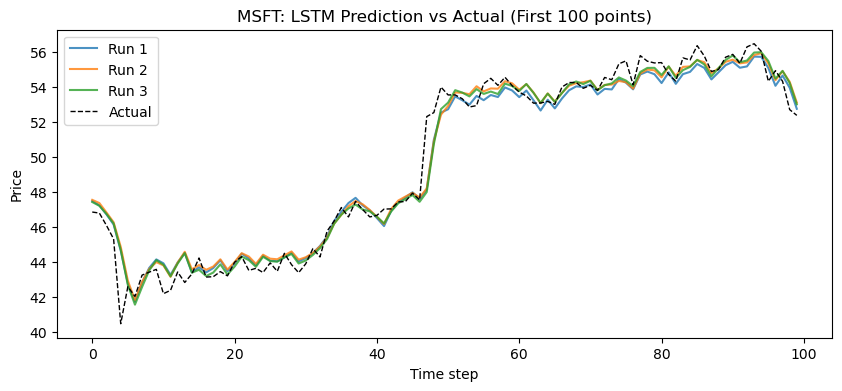

In [8]:
### >> Plot Prediction vs Actuaal 
# Plot predictions from each run
plt.figure(figsize=(10,4))
for i, pred in enumerate(predictions):
    plt.plot(pred["y_pred"], label=f"Run {pred['Run']}", alpha=0.8)

plt.plot(predictions[0]["y_test"], color="black", linewidth=1, linestyle="--", label="Actual")
plt.legend()
plt.title(f"{Tick}: LSTM Prediction vs Actual (All Data Points)")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.show()


# Plot the first 100 data points for detailed view
plt.figure(figsize=(10,4))
for i, pred in enumerate(predictions):
    plt.plot(pred["y_pred"][:100], label=f"Run {pred['Run']}", alpha=0.8)
plt.plot(predictions[0]["y_test"][:100], color="black", linewidth=1, linestyle="--", label="Actual")
plt.legend()
plt.title(f"{Tick}: LSTM Prediction vs Actual (First 100 points)")
plt.xlabel("Time step")
plt.ylabel("Price")
plt.show()


## Model Prediction 

In [9]:
##### >>> 5. Model Prediction 

### >> Consolidate data
all_dates = df.index

# dates corresponding to y
look_back = 20
dates_y = all_dates[look_back:]  # start from day 21

# split dates into train and test
dates_train = dates_y[:split]
dates_test = dates_y[split:]

results_all = pd.DataFrame({"Date": dates_test, "Actual": predictions[0]["y_test"]})

# Add all prediction columns
for i, pred in enumerate(predictions):
    results_all[f"Pred{i+1}"] = pred["y_pred"]

# Convert to long format
results_long = results_all.melt(
    id_vars='Date',
    value_vars=['Actual', 'Pred1', 'Pred2', 'Pred3'],
    var_name='Type',
    value_name='Price'
)

In [10]:
results_long

,Date,Type,Price
0,2015-08-18,Actual,46.840000
1,2015-08-19,Actual,46.779999
2,2015-08-20,Actual,46.070000
3,2015-08-21,Actual,45.299999
4,2015-08-24,Actual,40.450001
...,...,...,...
1383,2016-12-23,Pred3,62.544435
1384,2016-12-27,Pred3,62.217939
1385,2016-12-28,Pred3,62.581775
1386,2016-12-29,Pred3,62.253862


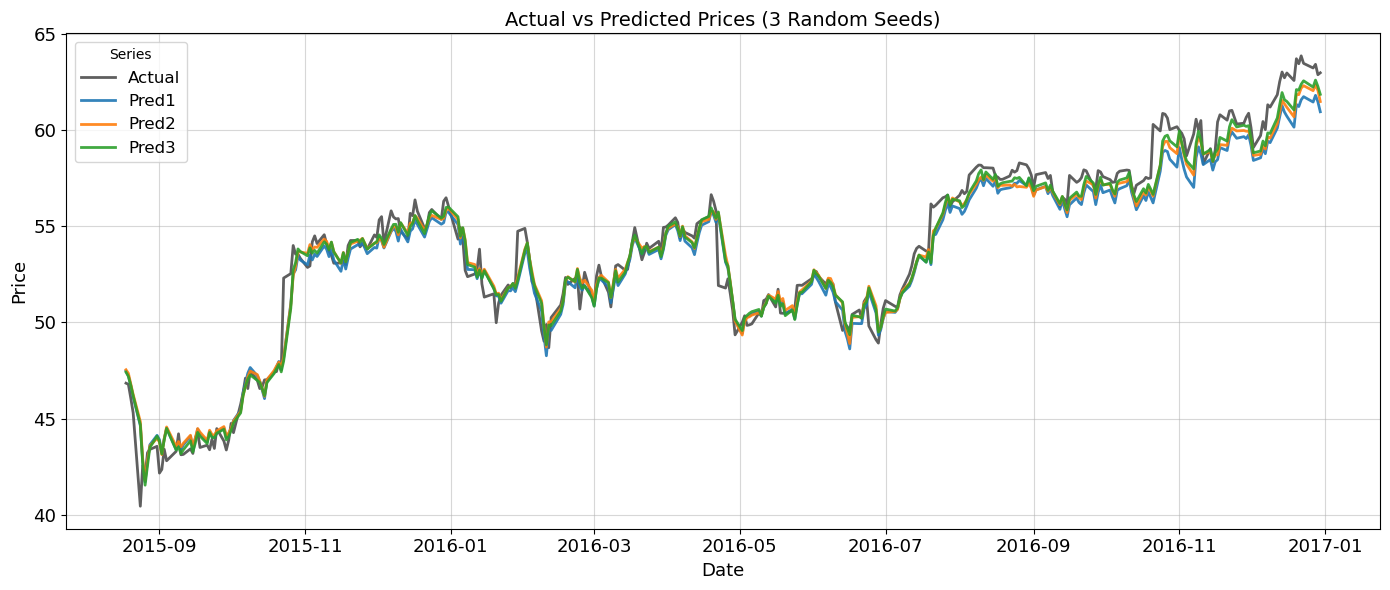

In [11]:
### >> Plot: Actual vs Predicted Price 
import seaborn as sns

plt.figure(figsize=(14,6))
palette = {"Actual": "#4e4e4e","Pred1": "#1f77b4", "Pred2": "#ff7f0e","Pred3": "#2ca02c"}

sns.lineplot(data=results_long,
             x='Date', y='Price', hue='Type', palette=palette, linewidth=2,alpha=0.9
)

plt.title("Actual vs Predicted Prices (3 Random Seeds)", fontsize=14)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Price", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.5)
plt.legend(title="Series", fontsize=12)
plt.tight_layout()
plt.show()



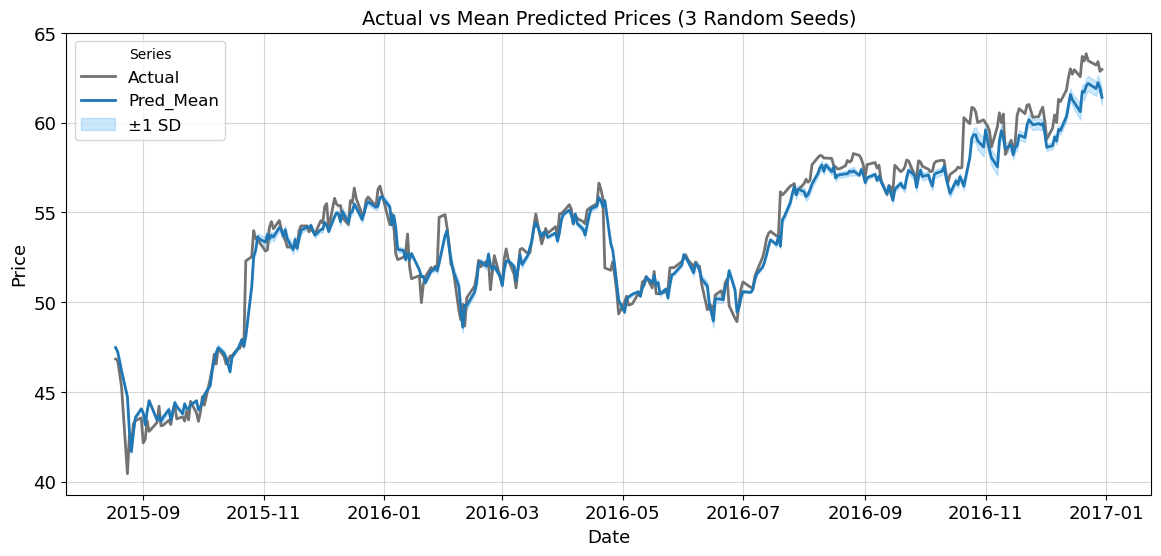

In [12]:
### Optional: Mean & Variability Band

results_all["Pred_Mean"] = results_all[["Pred1","Pred2","Pred3"]].mean(axis=1)
results_all["Pred_Std"] = results_all[["Pred1","Pred2","Pred3"]].std(axis=1)

plt.figure(figsize=(14,6))
plt.plot(results_all["Date"], results_all["Actual"], color="#727272", label="Actual", linewidth=2)
plt.plot(results_all["Date"], results_all["Pred_Mean"], color="#1f77b4", label="Pred_Mean", linewidth=2)
plt.fill_between(
    results_all["Date"],
    results_all["Pred_Mean"] - results_all["Pred_Std"],
    results_all["Pred_Mean"] + results_all["Pred_Std"],
    color="#008ff5", alpha=0.2, label="±1 SD"
)
plt.legend()
plt.grid(True, alpha=0.7)
plt.title("Actual vs Mean Predicted Prices (3 Random Seeds)",fontsize=14)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Price", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.5)
plt.legend(title="Series", fontsize=12)
plt.show()


In [23]:
### >> Plotly: Actual vs Predicted Price 
import plotly.graph_objects as go; fig = go.Figure()

# Actual line (gray)
fig.add_trace(go.Scatter(x=results_all["Date"], y=results_all["Actual"],
                         mode='lines', name='Actual',line=dict(color='#727272', width=2)))

# Mean predicted line (blue)
fig.add_trace(go.Scatter(x=results_all["Date"], y=results_all["Pred_Mean"],
                         mode='lines', name='Pred_Mean', line=dict(color='#1f77b4', width=2)))

# ±1 SD shaded band
fig.add_trace(go.Scatter(x=pd.concat([results_all["Date"], results_all["Date"][::-1]]),
                         y=pd.concat([results_all["Pred_Mean"] + results_all["Pred_Std"],
                                      (results_all["Pred_Mean"] - results_all["Pred_Std"])[::-1]]),
    fill='toself',
    fillcolor='rgba(31, 119, 180, 0.5)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    name='±1 SD'
))

# Layout with stronger grid
fig.update_layout(width=1200,height=600,
                title_font_size=20, xaxis_title_font_size=16,yaxis_title_font_size=16,legend_title_font_size=14,
                    #   plot_bgcolor=plot_bgcolor,        # plot area background
                    #   paper_bgcolor=background_color,   # figure background
                margin=dict(l=50, r=50, t=60, b=50),
    
                title="Actual vs Mean Predicted Prices (3 Random Seeds)",
                xaxis_title="Date",
                yaxis_title="Price",
                template="plotly_white",
                legend_title="Series",
                font=dict(size=13),
                hovermode="x unified",
                xaxis=dict(
                    showgrid=True,
                    gridcolor='lightgray',
                    gridwidth=1.5  # increase grid thickness
                ),
                yaxis=dict(
                    showgrid=True,
                    gridcolor='lightgray',
                    gridwidth=1.5  # increase grid thickness
                )
            )

fig.update_xaxes(tickfont=dict(size=14))
fig.update_yaxes(tickfont=dict(size=14))
fig.show()


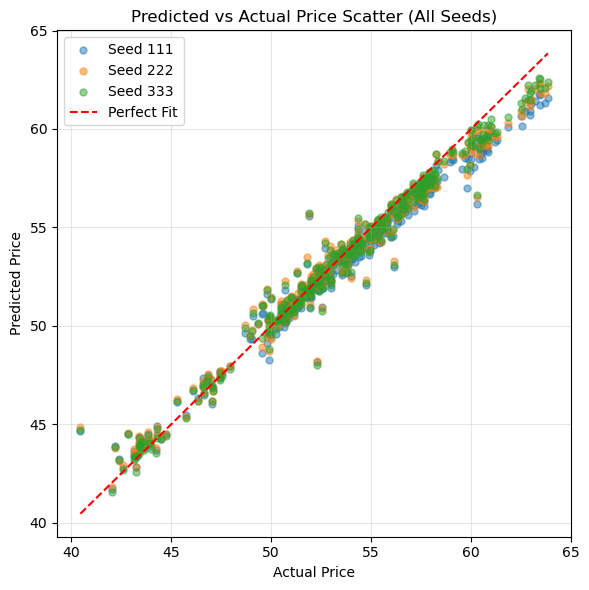

In [14]:
##### >>> Predicted vs Actual Plot 
## Overlay
plt.figure(figsize=(6,6))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

for i, pred in enumerate(predictions):
    plt.scatter(
        pred["y_test"],
        pred["y_pred"],
        alpha=0.5,
        s=25,
        color=colors[i],
        label=f"Seed {pred['Seed']}"
    )

# perfect prediction line
min_val = min([pred["y_test"].min() for pred in predictions])
max_val = max([pred["y_test"].max() for pred in predictions])
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Perfect Fit")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Price Scatter (All Seeds)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


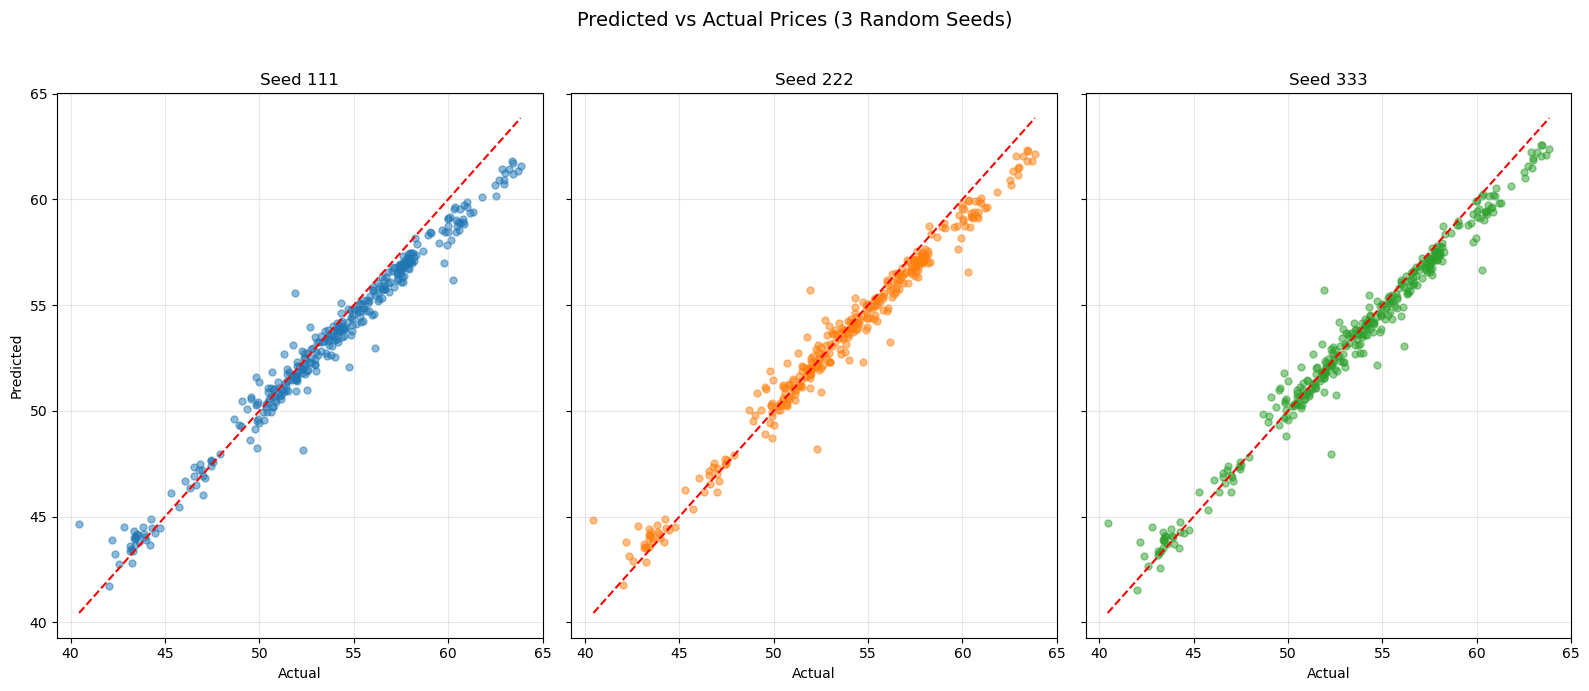

In [15]:
### Residual plot that compare three difference random run one panel per seed 

fig, axes = plt.subplots(1, 3, figsize=(16,7), sharex=True, sharey=True)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

for i, pred in enumerate(predictions):
    ax = axes[i]
    ax.scatter(pred["y_test"], pred["y_pred"], alpha=0.5, s=25, color=colors[i])
    ax.plot(
        [pred["y_test"].min(), pred["y_test"].max()],
        [pred["y_test"].min(), pred["y_test"].max()],
        color='red', linestyle='--'
    )
    ax.set_title(f"Seed {pred['Seed']}")
    ax.set_xlabel("Actual")
    if i == 0:
        ax.set_ylabel("Predicted")
    ax.grid(True, alpha=0.3)

plt.suptitle("Predicted vs Actual Prices (3 Random Seeds)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [16]:
##### >> 

def predict_over_history(df, model, scaler, look_back=20):
    """
    Generate next-day predictions over the full history of the dataset.
    
    Returns a DataFrame with:
      - actual_close: the actual close price
      - predicted_close: model's predicted next-day close
      - residual: difference between actual and predicted
    """
    n_features = df.shape[1]
    df_scaled = scaler.transform(df)
    
    predicted = []
    actual = []
    dates = []
    
    # slide over history
    for i in tqdm(range(look_back, len(df_scaled))):
        input_scaled = df_scaled[i-look_back:i, :].reshape(1, look_back, n_features)
        pred_scaled = model.predict(input_scaled, verbose=0)
        
        # inverse transform predicted close
        dummy = np.zeros((1, n_features))
        dummy[0, 0] = pred_scaled[0, 0]
        pred_close = scaler.inverse_transform(dummy)[0, 0]
        
        predicted.append(pred_close)
        actual.append(df['close'].values[i])
        dates.append(df.index[i])
    
    # create DataFrame
    pred_df = pd.DataFrame({
        'actual_close': actual,
        'predicted_close': predicted,
        'residual': np.array(actual) - np.array(predicted)
    }, index=dates)
    
    return pred_df


In [17]:
predictions_table = predict_over_history(df, model_lstm, scaler, look_back=20)
print(predictions_table.tail(10))  # last 10 days with predictions



100%|██████████| 1735/1735 [01:06<00:00, 26.26it/s]

            actual_close  predicted_close  residual
2016-12-16     62.299999        61.471971  0.828028
2016-12-19     63.619999        61.029782  2.590217
2016-12-20     63.540001        62.086893  1.453108
2016-12-21     63.540001        62.060972  1.479029
2016-12-22     63.549999        62.363043  1.186956
2016-12-23     63.240002        62.544443  0.695559
2016-12-27     63.279999        62.217944  1.062055
2016-12-28     62.990002        62.581775  0.408227
2016-12-29     62.900002        62.253862  0.646140
2016-12-30     62.139999        61.842185  0.297814


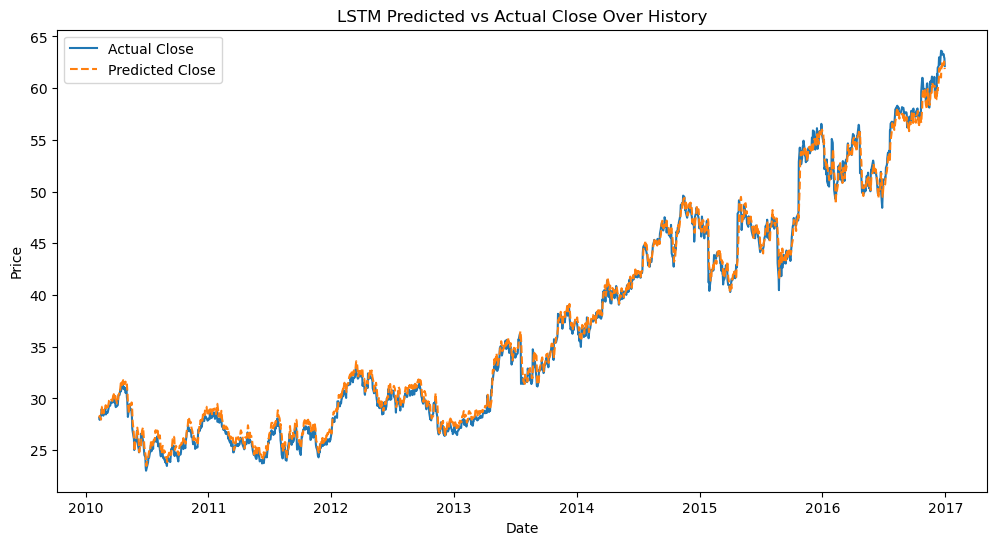

In [18]:

plt.figure(figsize=(12,6))
plt.plot(predictions_table.index, predictions_table['actual_close'], label='Actual Close')
plt.plot(predictions_table.index, predictions_table['predicted_close'], label='Predicted Close', linestyle='--')
plt.title('LSTM Predicted vs Actual Close Over History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [19]:
##### >>> Save Model

# model_lstm.save("aapl_lstm_model.h5")

# # Load in another script
# from tensorflow.keras.models import load_model
# model = load_model("aapl_lstm_model.h5")
